
# Pneumonia Detection using Transfer Learning with VGG16

This notebook demonstrates how to train a VGG16 model using transfer learning for pneumonia detection from chest X-ray images. The process involves data preprocessing, model setup using VGG16 with transfer learning, hyperparameter tuning using Keras Tuner, and training the model with callbacks like model checkpoints and early stopping.


In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.4 MB/s eta 0:00:00


In [ ]:
# import statements
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, Callback
from keras_tuner.tuners import RandomSearch
from google.colab import drive
from tensorflow.keras.metrics import Precision, Recall, AUC, BinaryAccuracy
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
from keras_tuner import RandomSearch
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to dataset
main_path = 'path_to_dataset'

In [ ]:
# Function to calculate global mean
def calculate_global_mean(image_data_generator, dataset_path, target_size=(224, 224), batch_size=32):
    mean_sum = np.zeros(3)
    total_images = 0

    generator = image_data_generator.flow_from_directory(
        dataset_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

    for images, _ in generator:
        # Rescale images to [0, 1] range if they aren't already
        images_rescaled = images / 255.0
        mean_sum += np.mean(images_rescaled, axis=(0, 1, 2)) * images.shape[0]
        total_images += images.shape[0]

        if total_images >= generator.samples:
            break

    global_mean = mean_sum / total_images
    return global_mean


In [ ]:
# Function to calculate global standard deviation
def calculate_global_std(image_data_generator, dataset_path, global_mean, target_size=(224, 224), batch_size=32):
    sum_squared_diff = np.zeros(3)
    total_images = 0

    generator = image_data_generator.flow_from_directory(
        dataset_path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

    for images, _ in generator:
        # Ensure images are rescaled to [0, 1] range if they aren't already
        images_rescaled = images / 255.0
        squared_diff = (images_rescaled - global_mean)**2
        sum_squared_diff += np.sum(squared_diff, axis=(0, 1, 2))
        total_images += images.shape[0]

        if total_images >= generator.samples:
            break

    global_variance = sum_squared_diff / (total_images * target_size[0] * target_size[1])
    global_std_dev = np.sqrt(global_variance)
    return global_std_dev

In [ ]:
image_data_generator = ImageDataGenerator()

# Calculate global mean
global_mean = calculate_global_mean(image_data_generator, main_path + '/train')

# Calculate global standard deviation
global_std = calculate_global_std(image_data_generator, main_path + '/train', global_mean)

Found 4686 images belonging to 2 classes.
Found 4686 images belonging to 2 classes.


In [ ]:
global_mean, global_std

(array([0.47894132, 0.47894132, 0.47894132]),
 array([0.23546351, 0.23546351, 0.23546351]))

In [ ]:
# Function to normalize images with the global mean and std
def normalize_image(image, global_mean, global_std):
    return (image - global_mean) / global_std

In [ ]:
# Function for partial application to set global mean/std
from functools import partial

# Partially apply normalize_image function with the global mean and std
normalize_image_global = partial(normalize_image, global_mean=global_mean, global_std=global_std)

# Data Generators with the normalization function using the global mean and std
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=normalize_image_global)
val_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=normalize_image_global)
test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=normalize_image_global)

# Generators
train_generator = train_datagen.flow_from_directory(
    main_path + '/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

validation_generator = val_datagen.flow_from_directory(
    main_path + '/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    main_path + '/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary')

Found 4686 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 585 images belonging to 2 classes.


### Visualizing Pre-Processing Steps

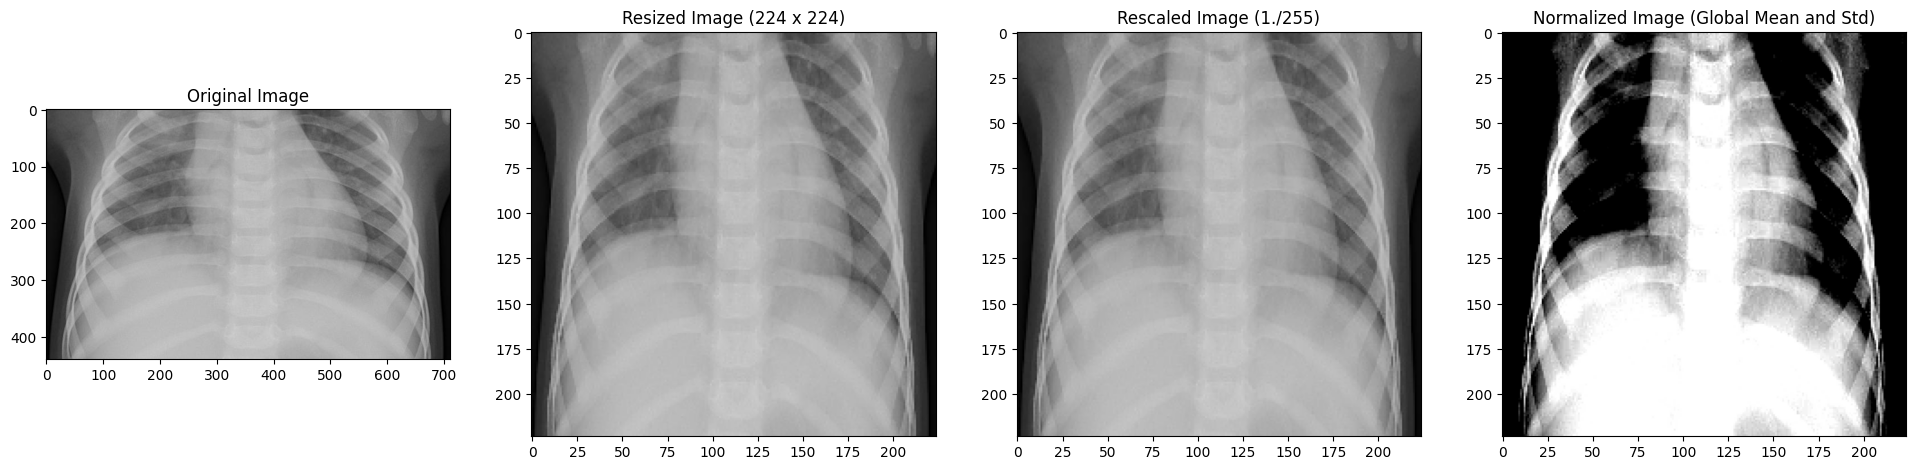

In [ ]:
original_image_path = 'path_to_image.jpeg'

# Load the original image without resizing
original_image = load_img(original_image_path)
original_image_array = img_to_array(original_image)

# Resize the image to 224 x 224 pixels
resized_image = load_img(original_image_path, target_size=(224, 224))
resized_image_array = img_to_array(resized_image)

# Rescale the resized image
rescaled_image_array = resized_image_array / 255.0

# Global mean and std
global_mean = np.array([0.47894132, 0.47894132, 0.47894132])
global_std = np.array([0.23546351, 0.23546351, 0.23546351])

# Normalize the rescaled image using global mean and std
normalized_image_array = (rescaled_image_array - global_mean) / global_std

# Display the images
plt.figure(figsize=(24, 6))

plt.subplot(1, 4, 1)
plt.imshow(np.squeeze(original_image_array / 255.0), cmap='gray')  # Dividing by 255 for display purposes
plt.title('Original Image')

# The resized image
plt.subplot(1, 4, 2)
plt.imshow(np.squeeze(resized_image_array / 255.0), cmap='gray')  # Dividing by 255 for display purposes
plt.title('Resized Image (224 x 224)')

# The rescaled image
plt.subplot(1, 4, 3)
plt.imshow(np.squeeze(rescaled_image_array), cmap='gray')
plt.title('Rescaled Image (1./255)')

# The normalized image
plt.subplot(1, 4, 4)

vmin, vmax = normalized_image_array.min(), normalized_image_array.max()
plt.imshow(np.squeeze(normalized_image_array), cmap='gray', vmin=vmin, vmax=vmax)
plt.title('Normalized Image (Global Mean and Std)')

plt.show()

### Data distribution

In [ ]:
train_classes = train_generator.class_indices
val_classes = validation_generator.class_indices
test_classes = test_generator.class_indices

# Function to count files in each class directory
def count_files(directory, classes):
    counts = {}
    for class_name, _ in classes.items():
        class_dir = os.path.join(directory, class_name)
        count = len(os.listdir(class_dir)) if os.path.exists(class_dir) else 0
        counts[class_name] = count
    return counts

# Counting files in each class
train_counts = count_files(main_path + '/train', train_classes)
val_counts = count_files(main_path + '/val', val_classes)
test_counts = count_files(main_path + '/test', test_classes)

# Printing the counts
print("Training Set Counts:", train_counts)
print("Validation Set Counts:", val_counts)
print("Test Set Counts:", test_counts)

Training Set Counts: {'NORMAL': 1267, 'PNEUMONIA': 3419}
Validation Set Counts: {'NORMAL': 158, 'PNEUMONIA': 427}
Test Set Counts: {'NORMAL': 158, 'PNEUMONIA': 427}


### Setting up metrics and hyperparameter tuning

In [ ]:
# Initialize metrics
precision_metric = Precision()
recall_metric = Recall()
auc_metric = AUC()
auc_pr_metric = AUC(curve='PR')  # PR curve AUC

def F1Score(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1_score

# Model Setup with VGG16 and Hyperparameter Tuning
def build_model(hp):
    base_model = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'),
        layers.Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            precision_metric,
            recall_metric,
            F1Score,
            auc_metric,
            auc_pr_metric
        ]
    )

    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='pneumonia_detection_normalized')

### Callbacks setup

In [ ]:
# Callbacks Setup
checkpoint = ModelCheckpoint('model-best-normalized.h5', save_best_only=True, monitor='val_accuracy', mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
csv_logger = CSVLogger('training_log_normalized.csv')

# Reset States Callback
class ResetStatesCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        precision_metric.reset_states()
        recall_metric.reset_states()
        auc_metric.reset_states()
        auc_pr_metric.reset_states()

# Include the ResetStatesCallback in your callbacks list
reset_states_callback = ResetStatesCallback()

In [ ]:
# Hyperparameter Search with all metrics being monitored
tuner.search(
    train_generator,
    epochs=50, # 50 Epochs
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, csv_logger, reset_states_callback]
)

Trial 10 Complete [00h 13m 17s]
val_accuracy: 0.9418803453445435

Best val_accuracy So Far: 0.9452991485595703
Total elapsed time: 02h 07m 47s


### Testing the model performance on test images

In [ ]:
# Load the best model
best_model_path = 'model-best-normalized.h5'
model = load_model(best_model_path, custom_objects={'F1Score': F1Score})

# Evaluate the model on the test data
test_loss, test_accuracy, test_precision, test_recall, test_f1score, test_auc, test_auc_pr = model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1score}")
print(f"Test AUC: {test_auc}")
print(f"Test AUC-PR: {test_auc_pr}")

19/19 [==============================] - 263s 15s/step - loss: 1.7430 - accuracy: 0.8547 - precision_3: 0.8340 - recall_3: 1.0000 - F1Score: 0.9423 - auc_6: 0.8177 - auc_7: 0.8813
Test Loss: 1.7429529428482056
Test Accuracy: 0.8547008633613586
Test Precision: 0.833984375
Test Recall: 1.0
Test F1 Score: 0.9423406720161438
Test AUC: 0.8177304267883301
Test AUC-PR: 0.8813266754150391


### Best hyperparameters

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
for hp in best_hps.space:
    print(f"{hp.name}: {best_hps.get(hp.name)}")

units: 160
dropout: 0.0
learning_rate: 0.0011465968378799715


In [ ]:
# Create a dictionary to store hyperparameters and their values
hp_dict = {hp.name: best_hps.get(hp.name) for hp in best_hps.space}

hp_df = pd.DataFrame(list(hp_dict.items()), columns=['Hyperparameter', 'Best Value'])

folder_path = 'folder_path/'
filename = "best_hyperparameters_normalized.csv"
full_path = folder_path + filename

hp_df.to_csv(full_path, index=False)

print(f"Best hyperparameters saved to {full_path}")

Best hyperparameters saved to /content/drive/MyDrive/AML - Group Project/best_hyperparameters_normalized.csv


### Learning curves

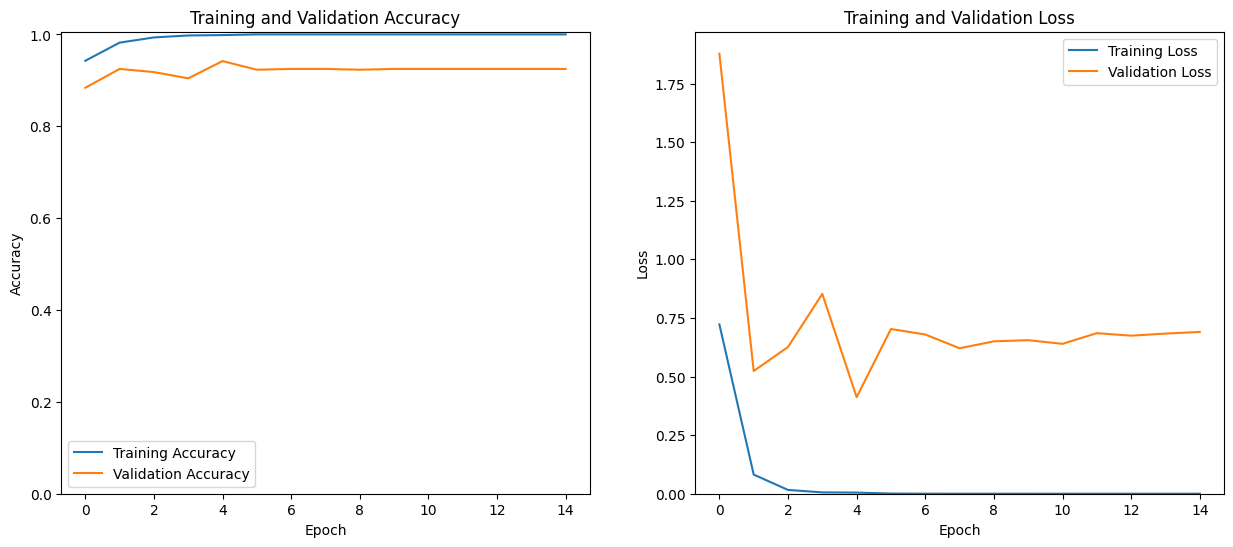

In [ ]:
# Load log file
data = pd.read_csv('training_log_normalized.csv')

# Plot metrics
plt.figure(figsize=(15, 6))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(data['epoch'], data['accuracy'], label='Training Accuracy')
plt.plot(data['epoch'], data['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.ylim(bottom=0)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(data['epoch'], data['loss'], label='Training Loss')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.ylim(bottom=0)
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

### Retraining model with best hyperparameters

In [ ]:
# Model Training with the Best Hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_generator, epochs=6, validation_data=validation_generator, callbacks=[checkpoint, early_stopping, csv_logger])

Epoch 1/6
147/147 [==============================] - ETA: 0s - loss: 0.1280 - accuracy: 0.9595 - precision_3: 0.9569 - recall_3: 0.9759 - F1Score: 0.9539 - auc_6: 0.9782 - auc_7: 0.9866

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/147 [==============================] - 55s 366ms/step - loss: 0.1280 - accuracy: 0.9595 - precision_3: 0.9569 - recall_3: 0.9759 - F1Score: 0.9539 - auc_6: 0.9782 - auc_7: 0.9866 - val_loss: 0.4459 - val_accuracy: 0.9077 - val_precision_3: 0.8910 - val_recall_3: 0.9953 - val_F1Score: 0.9469 - val_auc_6: 0.9373 - val_auc_7: 0.9569
Epoch 2/6
147/147 [==============================] - 54s 364ms/step - loss: 0.0259 - accuracy: 0.9910 - precision_3: 0.9941 - recall_3: 0.9936 - F1Score: 0.9940 - auc_6: 0.9994 - auc_7: 0.9998 - val_loss: 0.2597 - val_accuracy: 0.9316 - val_precision_3: 0.9179 - val_recall_3: 0.9953 - val_F1Score: 0.9541 - val_auc_6: 0.9657 - val_auc_7: 0.9768
Epoch 3/6
147/147 [==============================] - 53s 362ms/step - loss: 0.0074 - accuracy: 0.9983 - precision_3: 0.9988 - recall_3: 0.9988 - F1Score: 0.9980 - auc_6: 1.0000 - auc_7: 1.0000 - val_loss: 0.3529 - val_accuracy: 0.9179 - val_precision_3: 0.9006 - val_recall_3: 0.9977 - val_F1Score: 0.9536 - val_auc_6:

### Performance of retrained model on test images

In [ ]:
# Evaluate the model on the test data
test_loss_full, test_accuracy_full, test_precision_full, test_recall_full, test_f1score_full, test_auc_full, test_auc_pr_full = model.evaluate(test_generator)

print(f"Test Loss: {test_loss_full}")
print(f"Test Accuracy: {test_accuracy_full}")
print(f"Test Precision: {test_precision_full}")
print(f"Test Recall: {test_recall_full}")
print(f"Test F1 Score: {test_f1score_full}")
print(f"Test AUC: {test_auc_full}")
print(f"Test AUC-PR: {test_auc_pr_full}")

19/19 [==============================] - 5s 249ms/step - loss: 1.3947 - accuracy: 0.8171 - precision_3: 0.7996 - recall_3: 1.0000 - F1Score: 0.8773 - auc_6: 0.7978 - auc_7: 0.8701
Test Loss: 1.3947443962097168
Test Accuracy: 0.8170940279960632
Test Precision: 0.7996254563331604
Test Recall: 1.0
Test F1 Score: 0.8773338198661804
Test AUC: 0.7977573871612549
Test AUC-PR: 0.870103120803833


### Learning curves for retrained model

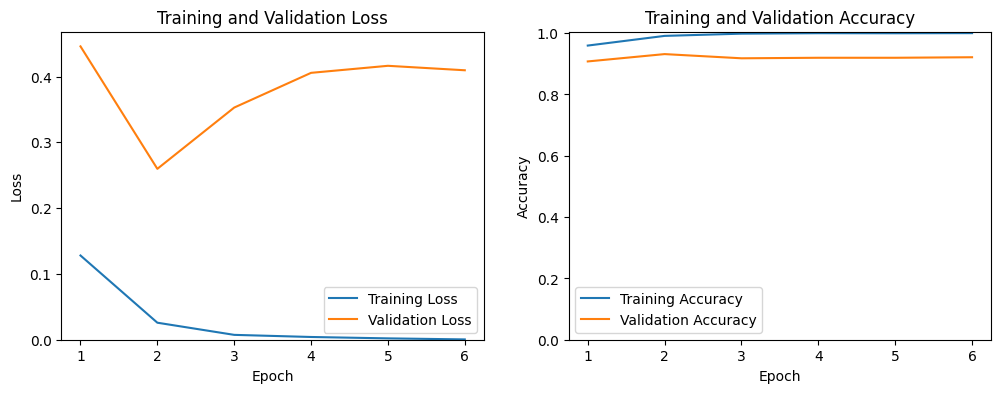

In [ ]:
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(12, 4))

# Plotting Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.ylim(bottom=0)

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.legend()
plt.ylim(bottom=0)

# plt.savefig("Learning Curves.png", dpi=300)
plt.show()

### Storing history df

In [ ]:
history_df = pd.DataFrame(history.history)

history_df['epoch'] = history_df.index + 1

file_path = 'model_history.csv'

history_df.to_csv(file_path, index=False)

In [ ]:
model_path = 'VGG16_trained_new_data.h5'

### Saving the Model

In [ ]:
# Save the model
model.save(model_path)

print(f"Model saved to {model_path}")

In [ ]:
# Load the model
loaded_model = load_model(model_path)

In [ ]:
loaded_model.layers[0].summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21137729 (80.63 MB)
Trainable params: 6423041 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


### Sample predictions

In [ ]:
# Make predictions on the test set
predictions = loaded_model.predict(test_generator, steps=len(test_generator))

19/19 [==============================] - 4s 214ms/step


In [ ]:
# Get the actual labels
actual_labels = test_generator.classes

# Decide how many images you want to display
num_images_to_display = 12

# Randomly select images to display
indices_to_display = np.random.choice(range(len(predictions)), num_images_to_display, replace=False)

In [ ]:
array = actual_labels

In [ ]:
# Counting 1's
count_ones = np.count_nonzero(array)

# Counting 0's (total length minus the count of 1's)
count_zeros = len(array) - count_ones

print("Number of 0's:", count_zeros)
print("Number of 1's:", count_ones)

Number of 0's: 158
Number of 1's: 427


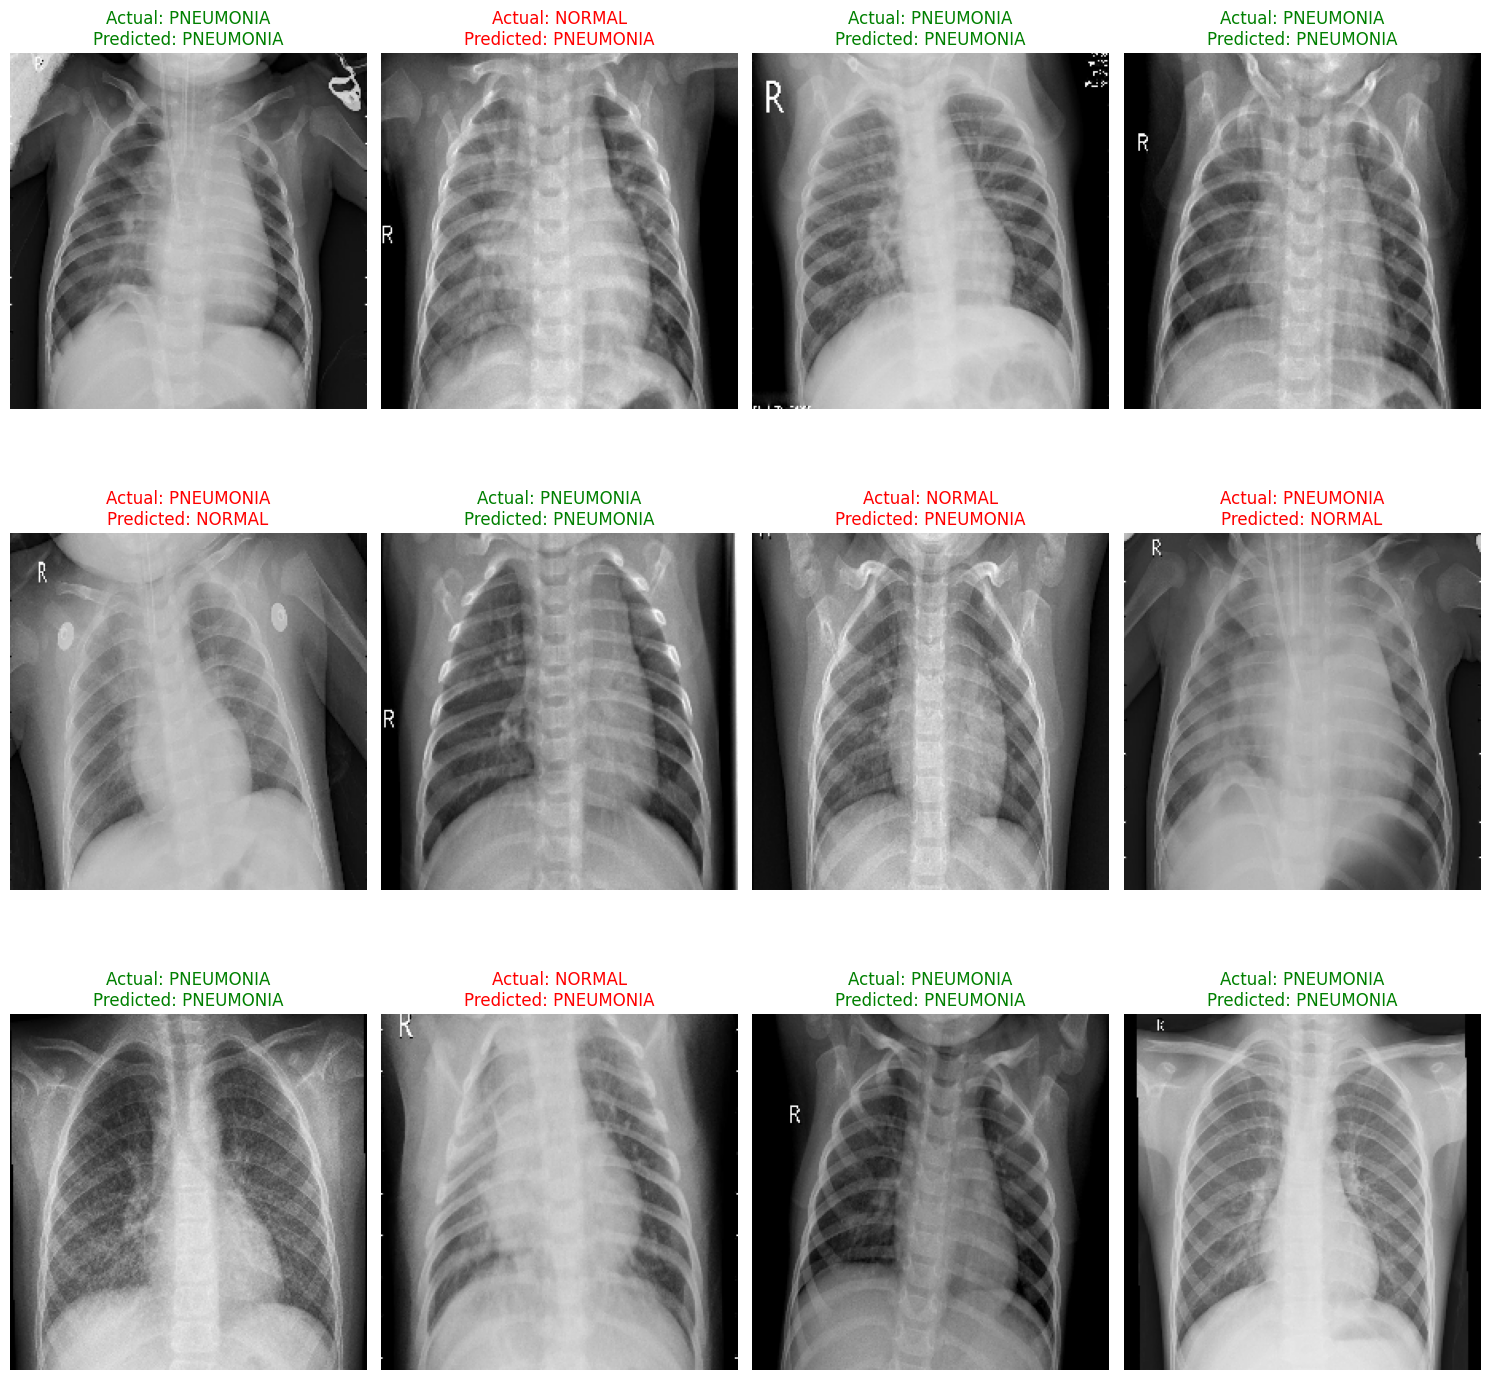

In [ ]:
plt.figure(figsize=(15, 15))

for i, idx in enumerate(indices_to_display):
    plt.subplot(3, 4, i + 1)

    # Retrieve the image by resetting and iterating through the generator
    test_generator.reset()
    for _ in range(idx):
        x, y = next(test_generator)

    plt.imshow(x[0], cmap='gray')
    plt.axis('off')

    # Determine actual and predicted labels
    actual_label = 'PNEUMONIA' if actual_labels[idx] == 1 else 'NORMAL'
    predicted_label = 'PNEUMONIA' if predictions[idx] > 0.5 else 'NORMAL'

    title_color = 'green' if actual_label == predicted_label else 'red'

    plt.title(f'Actual: {actual_label}\nPredicted: {predicted_label}', color=title_color)

plt.tight_layout()

# plt.savefig("predictions_new_data.png", dpi=300)
plt.show()

### Confusion matrix

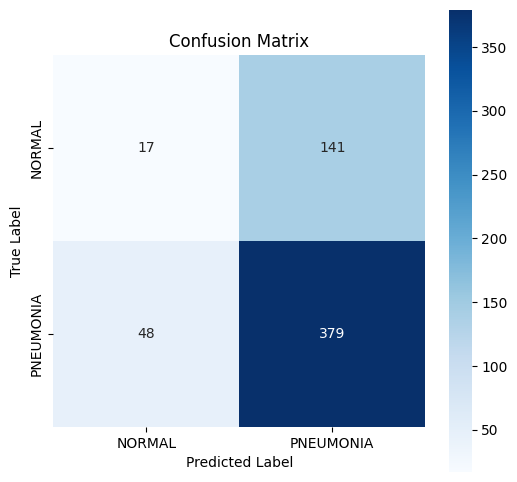

In [ ]:
# Convert predictions to binary (0 or 1) using a threshold (e.g., 0.5)
binary_predictions = np.where(predictions > 0.5, 1, 0).flatten()

# Calculate the confusion matrix
cm = confusion_matrix(actual_labels, binary_predictions)

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True,
            xticklabels=['NORMAL', 'PNEUMONIA'],
            yticklabels=['NORMAL', 'PNEUMONIA'])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

# plt.savefig("confusion_matrix_new_data.png", dpi=300)
plt.show()